# <font size="25" color="indianred">Data generation Burgers' equation

# <font size="5" color="steelblue"> Cole-Hopf transformation to obtain Burgers' equation out of the Heat equation

Numerical groundtruth data for the Burgers' equation $$u_t + uu_x - \nu u_{xx} = 0 $$ with viscosity parameter $\nu$ is obtained by solving the Heat equation. This is possible due to the Cole-Hopf transformation
$
    u = 2\nu \frac{\partial}{\partial x} \log(\phi) \ ,
$
which turns the Burgers' equation into the Heat equation:
$$
    \phi_t = \nu \phi_{xx} \ .
$$
    
The procedure is the following:
    * Sample initial conditions for the Burgers' equation
    * Apply an inverse Cole-Hopf transformation to convert the sampled initial conditions into initial conditions of the Heat equation
    * Solve the Heat equation
    * Apply forward Cole-Hopf transformation to turn trajectories into trajectories of the Burgers' equation
    
In the last step, we can leverage the fact that the Burgers' equation has an extra **infinite dimensional subalgebra** $g_\alpha$, which is not a Lie group symmetry, but for any two solutions $u, \alpha$, we can return a new one as $2\nu \log \left ( (1-\epsilon)e^{\frac{1}{2\nu}u(x,t)} + \epsilon e^{\frac{1}{2\nu}\alpha(x,t)} \right )$ for $\epsilon\in[0,1]$.

# <font size="5" color="steelblue">Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from typing import Optional
from scipy.integrate import solve_ivp
from scipy.fftpack import diff as psdiff
# from common.augmentation import fourier_shift
def fourier_shift(u: torch.Tensor, eps: float=0., dim: int=-1, order: int=0) -> torch.Tensor:
    """
    Shift in Fourier space.
    Args:
        u (torch.Tensor): input tensor, usually of shape [batch, t, x]
        eps (float): shift parameter
        dim (int): dimension which is used for shifting
        order (int): derivative order
    Returns:
        torch.Tensor: Fourier shifted input
    """
    assert dim < 0
    n = u.shape[dim]
    u_hat = torch.fft.rfft(u, dim=dim, norm='ortho')
    # Fourier modes
    omega = torch.arange(n // 2 + 1)
    if n % 2 == 0:
        omega[-1] *= 0
    # Applying Fourier shift according to shift theorem
    fs = torch.exp(- 2 * np.pi * 1j * omega * eps)
    # For order>0 derivative is taken
    fs = (- 2 * np.pi * 1j * omega) ** order * fs
    for _ in range(-dim - 1):
        fs = fs[..., None]
    return torch.fft.irfft(fs * u_hat, n=n, dim=dim, norm='ortho')

##############################################
## New imports:
from scipy.integrate import cumulative_simpson
##############################################

# <font size="5" color="steelblue">Generate initial conditions
    
Initial conditions are sampled from a distribution over truncated Fourier series with random coefficients 
$\{A_k, \ell_k, \phi_k\}_k$ as
$$
    u_0(x) = \sum_{k=1}^N A_k \sin(2 \pi \ell_k x / L + \phi_k) \ .
$$
Since we are solving for the Heat equation, we first need to transform the initial conditions of the Burgers' equation back to the Heat equation via an inverse Cole-Hopf transformation.

In [2]:
def generate_params() -> (int, np.ndarray, np.ndarray, np.ndarray):
    """
    Returns parameters for initial conditions.
    Args:
        None
    Returns:
        int: number of Fourier series terms
        np.ndarray: amplitude of different sine waves
        np.ndarray: phase shift of different sine waves
        np.ndarray: frequency of different sine waves
    """
    N = 10
    lmin, lmax = 1, 3
    A = (np.random.rand(1, N) - 0.5)
    phi = 2.0*np.pi*np.random.rand(1, N)
    l = np.random.randint(lmin, lmax, (1, N))
    return (N, A, phi, l)

def initial_conditions(x: np.ndarray, 
                       L: int, 
                       nu: float, 
                       scale: float= 10, 
                       params: Optional[list]=None) -> np.ndarray:
    """
    Return initial conditions based on initial parameters.
    Args:
        x (np.ndarray): input array of spatial grid
        L (float): length of the spatial domain
        nu (float): viscosity parameter
        scale (float): scale parameter for inverse Cole-Hopf transformation
        params (Optinal[list]): input parameters for generating initial conditions
    Returns:
        np.ndarray: initial condition
    """
    if params is None:
        params = generate_params()
    N, A, phi, l = params
    # Burgers' equation solution
    psi0 = np.sum(A * np.sin((2 * np.pi * l * x[:, None] / L ) + phi), -1)
    return psi0

# <font size="5" color="steelblue">Cole-Hopf transformation and solving to the Heat equation

In [3]:
def cole_hopf(psi: np.ndarray, nu: float, L: float) -> np.ndarray:
    """
    Cole-Hopf transformation which transforms a trajectory of the Heat equation into the Burgers' equation.
    Args:
        psi (np.ndarray): input trajectory of the Heat equation
        nu (float): diffusion coefficient
        L (float): length of spatial domain
    Returns:
        np.ndarray: Cole-Hopf transformed trajectory of the Burgers' equation
    """
    psi_max = np.amax(psi, axis=-1, keepdims=True)
    psi_min = np.amin(psi, axis=-1, keepdims=True)
    psi = psi / (psi_max - psi_min)
    psix = fourier_shift(torch.tensor(psi), order=1).numpy()
    return -(psix / psi) / (2 * nu)

def inv_cole_hopf(psi0: np.ndarray, scale: float = 10.) -> np.ndarray:
    """
    Inverse Cole-Hopf transformation to obtain Heat equation out of initial conditions of Burgers' equation.
    Args:
        psi0 (np.ndarray): Burgers' equation (at arbitrary timestep) which gets transformed into Heat equation
        scale (float): scaling factor for transformation
    Returns:
        np.ndarray: transformed Heat equation
    """
    psi0 = psi0 - np.amin(psi0)
    psi0 = scale * 2 * ((psi0 / np.amax(psi0)) - 0.5)
    psi0 = np.exp(psi0)
    return psi0

##############################################
## New functions: cole_hopf_new and inv_cole_hopf_new
## Note that cole_hopf_new maps the nonlinear Burgers' equation to the linear heat equation,
## this is the opposite of the original cole_hopf.
def gradient_circular(f, spacing=1.0):
    """
    Compute the gradient of a 1D array using central differences with circular boundary conditions.
    
    Parameters:
    f (array-like): Input array
    spacing (float): Spacing between f values. Default is 1.0.
    
    Returns:
    ndarray: Gradient of the input array
    """
    f = np.asarray(f)
    N = f.shape[0]
    
    # Use float64 for higher precision
    grad = np.zeros(N, dtype=np.float64)
    
    # Compute gradient using central differences with circular boundary
    grad = (np.roll(f, -1) - np.roll(f, 1)) / (2 * spacing)
    
    return grad

def cole_hopf_new(u, X, v):
    '''
    Map the solution of the Burgers' equation to the solution of the heat equation.
    '''
    ## Integrate: int_{-\infty}^{x} u(x') dx'
    u_int = cumulative_simpson(u, x=X, initial=0)
    ## Apply the Cole-Hopf transform
    return np.exp((1 / (-2 * v)) * u_int)

def inv_cole_hopf_new(u, X, v):
    '''
    Map the solution of the heat equation to the solution of the Burgers' equation.
    '''
    ## Differentiate u
    u_diff = gradient_circular(u, X[1] - X[0])
    ## Apply the inverse Cole-Hopf transform
    return -2 * v * u_diff / u 
##############################################


def heat_pseudospectral(t: float, u: np.ndarray, L: float, nu: float) -> np.ndarray:
    """
    Compute spatial derivatives for the Heat equation, using a pseudospectral method, descretization in x.
    Args:
        t (float): time point
        u (np.ndarray): 1D input field
        L (float): length of the spatial domain
        nu (float): viscosity coefficient
    Returns:
        np.ndarray: reconstructed pseudospectral time derivative
    """
    # Compute the x derivatives using the pseudo-spectral method.
    uxx = psdiff(u, period=L, order=2)
    # Compute du/dt.    
    dudt = nu * uxx #- F(t) * u
    return dudt

In [4]:
def sample_heat(ic_burgers, x: np.ndarray, t: np.ndarray, nu: float, tol: float=1e-9) -> np.ndarray:
    """
    Sample different trajectories of the Heat equation.
    Args:
        x (np.ndarray): spatial grid
        t (np.ndarray): temporal grid
        nu (float): viscosity coefficient 
        tol (float): tolerance of solver
    Returns:
        torch.Tensor: solved trajectory
    """
    # psi0 = initial_conditions(x, L, nu, scale=10)
    ic_heat = inv_cole_hopf(ic_burgers)
    # Compute the solution
    sol = solve_ivp(heat_pseudospectral, [t[0], t[-1]], ic_heat, method='Radau', t_eval=t, args=(L, nu))#, atol=tol, rtol=tol)
    return sol.y.T

##############################################
## New functions sample_heat_new
def sample_heat_new(ic_burgers, x: np.ndarray, t: np.ndarray, nu: float, tol: float=1e-9) -> np.ndarray:
    # psi0 = initial_conditions(x, L, nu, scale=10)
    ic_heat = cole_hopf_new(ic_burgers, x, nu)
    # Compute the solution
    sol = solve_ivp(heat_pseudospectral, [t[0], t[-1]], ic_heat, method='Radau', t_eval=t, args=(L, nu))#, atol=tol, rtol=tol)
    return sol.y.T
##############################################

# <font size="5" color="steelblue">Sampling Heat equations and Cole-Hopf transformation into Burgers' equation
    
We have now everything together to solve the Heat equation for different initial conditions. We can further leverage the fact that the Burgers' equation has an extra **infinite dimensional subalgebra** $g_\alpha$, which is not a Lie group symmetry, but for any two solutions $u, \alpha$, we can return a new one as $2\nu \log \left ( (1-\epsilon)e^{\frac{1}{2\nu}u(x,t)} + \epsilon e^{\frac{1}{2\nu}\alpha(x,t)} \right )$ for $\epsilon\in[0,1]$

In [5]:
nu = 0.08 ## New CHANGED THIS TO BE LARGER FOR STABILITY
L = 2 * np.pi
N = 2**8
x = np.linspace(0, (1-1.0/N)*L, N)
T = 2**4
t = np.linspace(0, T, N)

ic_burgers1 = initial_conditions(x, L, nu)
ic_burgers2 = initial_conditions(x, L, nu)

psi1 = sample_heat(ic_burgers1, x, t, nu)
psi1_new = sample_heat_new(ic_burgers1, x, t, nu) ## New
psi2 = sample_heat(ic_burgers2, x, t, nu)
psi2_new = sample_heat_new(ic_burgers2, x, t, nu) ## New

psi3 = psi1 + psi2
psi3_new = psi1_new + psi2_new ## New
psis = [psi1, psi2, psi3]
psis_new = [psi1_new, psi2_new, psi3_new] ## New

u1 = cole_hopf(psi1, nu, L)

u1_new = np.zeros_like(u1) ## New
for i in range(256):
    u1_new[i] = inv_cole_hopf_new(psi1_new[i], x, nu) 

u2 = cole_hopf(psi2, nu, L)

u2_new = np.zeros_like(u1) ## New
for i in range(256):
    u2_new[i] = inv_cole_hopf_new(psi2_new[i], x, nu)

u3 = cole_hopf(psi3, nu, L)

u3_new = np.zeros_like(u1) ## New
for i in range(256):
    u3_new[i] = inv_cole_hopf_new(psi3_new[i], x, nu)

us = [u1, u2, u3]
us_new = [u1_new, u2_new, u3_new] ## New

# <font size="5" color="steelblue">Visualizing results
    
Plot the results of different trajectories of the Heat equation and the respective Cole-Hopf transformed trajectories of the Burgers' equation.

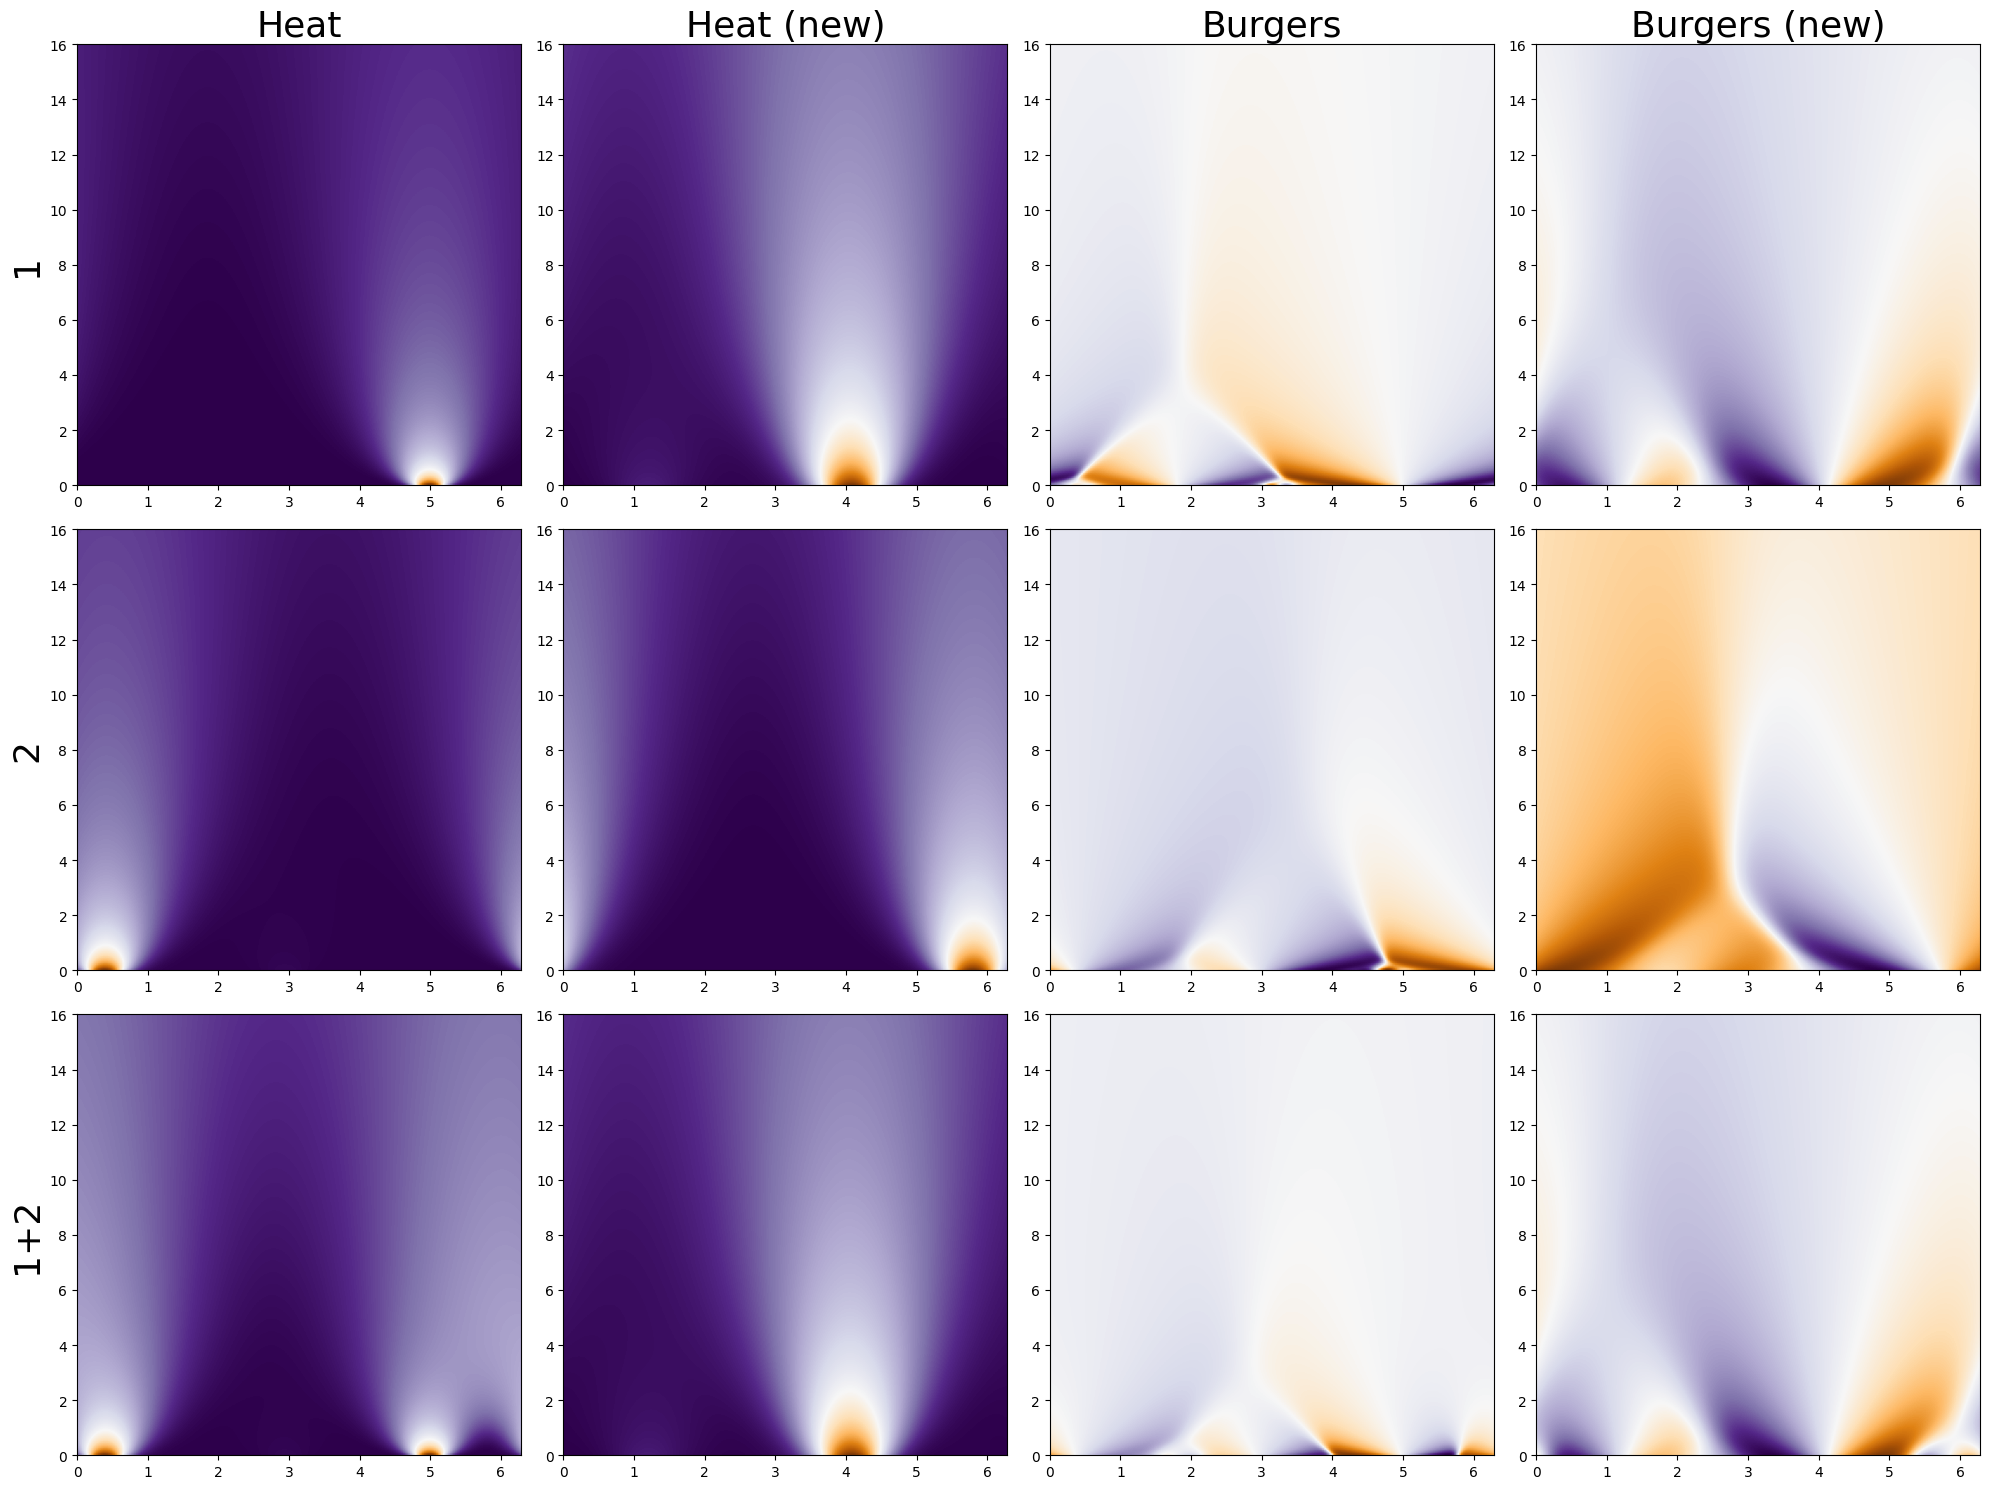

In [6]:
xticks = np.linspace(0, 2*np.pi, 6)
yticks = np.linspace(0, 16, 4)

# plt.figure(figsize=(14,20))
# for i, (psi, u) in enumerate(zip(psis, us)):
#     ax = plt.subplot(3, 2, 1+i*2)
#     field = plt.imshow(psi[::-1,:], cmap='PuOr_r',  extent=[0,2*np.pi,0,16], norm=SymLogNorm(linthresh=4000))
#     ax.set_aspect(0.3)
#     plt.xlabel('$x$ [m]', fontsize=26)
#     plt.ylabel('$t$ [s]', fontsize=26)
#     if i < 2:
#         title = f'Heat {i+1}'
#     else:
#         title = f'Heat 1+2'
#     plt.title(title, fontsize=26)
#     plt.yticks(fontsize=22)
#     plt.xticks(fontsize=22)

    
# for i, (psi, u) in enumerate(zip(psis, us)):
#     ax = plt.subplot(3, 2, 2+i*2)
#     plt.imshow(u[::-1,:], cmap='PuOr_r', extent=[0,2*np.pi,0,16], norm=SymLogNorm(linthresh=1000)) 
#     ax.set_aspect(0.3)
#     plt.xlabel('$x$ [m]', fontsize=26)
#     plt.ylabel('$t$ [s]', fontsize=26)
#     if i < 2:
#         title = f'Burgers\' {i+1}'
#     else:
#         title = f'Burgers\' 1+2'
#     plt.title(title, fontsize=26)
#     plt.yticks(fontsize=22)
#     plt.xticks(fontsize=22)

##############################################
## New plots
fig, ax = plt.subplots(3, 4, figsize=(20, 15))

ax[0, 0].imshow(psi1[::-1,:], cmap='PuOr_r', aspect='auto', extent=[0,2*np.pi,0,16]) # , norm=SymLogNorm(linthresh=4000)
ax[0, 0].set_title('Heat', fontsize=26)
ax[0, 0].set_ylabel('1', fontsize=26)

ax[1, 0].imshow(psi2[::-1,:], cmap='PuOr_r', aspect='auto', extent=[0,2*np.pi,0,16]) # , norm=SymLogNorm(linthresh=4000)
ax[1, 0].set_ylabel('2', fontsize=26)
 
ax[2, 0].imshow(psi3[::-1,:], cmap='PuOr_r', aspect='auto', extent=[0,2*np.pi,0,16]) # , norm=SymLogNorm(linthresh=4000)
ax[2, 0].set_ylabel('1+2', fontsize=26)

ax[0, 1].imshow(psi1_new[::-1,:], cmap='PuOr_r', aspect='auto', extent=[0,2*np.pi,0,16]) # , norm=SymLogNorm(linthresh=4000)
ax[0, 1].set_title('Heat (new)', fontsize=26)

ax[1, 1].imshow(psi2_new[::-1,:], cmap='PuOr_r', aspect='auto', extent=[0,2*np.pi,0,16]) # , norm=SymLogNorm(linthresh=4000)
ax[2, 1].imshow(psi3_new[::-1,:], cmap='PuOr_r', aspect='auto', extent=[0,2*np.pi,0,16]) # , norm=SymLogNorm(linthresh=4000)

ax[0, 2].imshow(u1[::-1,:], cmap='PuOr_r', aspect='auto', extent=[0,2*np.pi,0,16]) # , norm=SymLogNorm(linthresh=1000)
ax[0, 2].set_title('Burgers', fontsize=26)

ax[1, 2].imshow(u2[::-1,:], cmap='PuOr_r', aspect='auto', extent=[0,2*np.pi,0,16]) # , norm=SymLogNorm(linthresh=1000)
ax[2, 2].imshow(u3[::-1,:], cmap='PuOr_r', aspect='auto', extent=[0,2*np.pi,0,16]) # , norm=SymLogNorm(linthresh=1000)

ax[0, 3].imshow(u1_new[::-1,:], cmap='PuOr_r', aspect='auto', extent=[0,2*np.pi,0,16]) # , norm=SymLogNorm(linthresh=1000)
ax[0, 3].set_title('Burgers (new)', fontsize=26)

ax[1, 3].imshow(u2_new[::-1,:], cmap='PuOr_r', aspect='auto', extent=[0,2*np.pi,0,16]) # , norm=SymLogNorm(linthresh=1000)
ax[2, 3].imshow(u3_new[::-1,:], cmap='PuOr_r', aspect='auto', extent=[0,2*np.pi,0,16]) # , norm=SymLogNorm(linthresh=1000)

# plt.xlabel('$x$ [m]', fontsize=26)
# plt.ylabel('$t$ [s]', fontsize=26)

plt.tight_layout()
##############################################
    
plt.show()

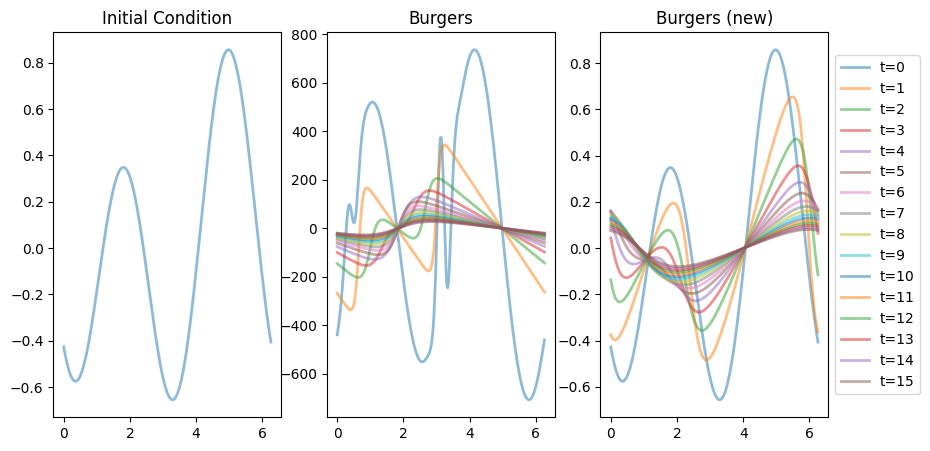

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))


ax[0].plot(x, ic_burgers1, label='t=0', alpha=0.5, linewidth=2)
for i in range(0, 256, 16):
    ax[1].plot(x, u1[i], label=f't={t[i]:.0f}', alpha=0.5, linewidth=2)
    ax[2].plot(x, u1_new[i], label=f't={t[i]:.0f}', alpha=0.5, linewidth=2)

ax[0].set_title('Initial Condition')
ax[1].set_title('Burgers')
ax[2].set_title('Burgers (new)')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))